In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas_datareader import data
import datetime
import copy


In [155]:
def get_index_data(tickers, start_date, end_date):
    data_list = []
    volume_close_data = []
    column_names = []
    
    for t in tickers:
        data_list.append(data.DataReader(t, 'yahoo', start_date, end_date))
        column_names.extend([t+'_volume', t+'_close'])
                             
    for dat in data_list:
        volume_close_data.append(dat[['Volume', 'Adj Close']])
        
    result = pd.concat(volume_close_data, axis=1)
    result.columns = column_names
    return result

def get_target_data(ticker, start_date, end_date):
    target_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
    target_data = target_data[['Volume', 'Close']]
    target_data.columns = ['volume', 'close']
    return target_data

def build_moving_avg(target_data, windows=[10, 20, 40, 80, 160]):
    mvoing_avg_graphs = []
    column_names = []
    for win in windows:
        moving_avg = target_data.rolling(window=win).mean()
        column_names.append(str(win)+'_avg_close')
        mvoing_avg_graphs.append(moving_avg)
    result = pd.concat(mvoing_avg_graphs, axis=1)
    result.columns = column_names
    return result

def get_y_value(target_data, shift_size=5):
    y = copy.copy(target_data)
    y[:-shift_size] = target_data[shift_size:]
    y.rename('Y')
    return y

def build_max_min_graph(target_data, windows=[3,5,10,20,40]):
    max_min_graphs = []
    column_names = []
    for win in windows:
        half = int(win/2)
        max_graph = copy.copy(target_data)
        min_graph = copy.copy(target_data)
        column_names.append(str(win)+'_days_max')
        column_names.append(str(win)+'_days_min')
        max_graph[:half] = max(target_data[:half])
        min_graph[:half] = min(target_data[:half])
        
        for i in range(half,len(target_data)-half):
            max_graph[i] = max(target_data[i-half:i+half])
            min_graph[i] = min(target_data[i-half:i+half])
        
        max_graph[-half:] = max(target_data[-half:])
        min_graph[-half:] = min(target_data[-half:])
            
        max_min_graphs.append(max_graph)
        max_min_graphs.append(min_graph)
    result = pd.concat(max_min_graphs, axis=1)
    result.columns = column_names
    return result

def bollinger_bands(df, n):
    """
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean())
    MSD = pd.Series(df['Close'].rolling(n, min_periods=n).std())
    b1 = 4 * MSD / MA
    B1 = pd.Series(b1, name='BollingerB_' + str(n))
    df = df.join(B1)
    b2 = (df['Close'] - MA + 2 * MSD) / (4 * MSD)
    B2 = pd.Series(b2, name='Bollinger%b_' + str(n))
    df = df.join(B2)
    return df


In [161]:
start_date = '2015-01-01'
end_date = '2017-01-01'
index_list = ['^GSPC', '^DJI', '^IXIC', '^RUT']
moving_windows = [10, 20, 40, 80, 160]
max_min_windows = [3,5,7,11,21]

In [162]:
#target_data = get_target_data('AAPL', start_date, end_date)

test_data = target_data[:100]
index_data = get_index_data(index_list, start_date, end_date )
moving_avg_data = build_moving_avg(test_data['close'], moving_windows)
max_min_graph = build_max_min_graph(test_data['close'], max_min_windows)

Y = get_y_value(test_data['close'], 5)

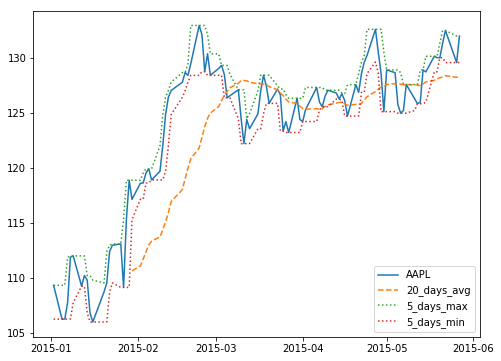

In [170]:
figure(num=None, figsize=(8,6))
plt.plot(test_data['close'], label='AAPL')
plt.plot(moving_avg_data['20_avg_close'], label='20_days_avg', linestyle='--')
plt.plot(max_min_graph['5_days_max'], label='5_days_max', linestyle=':')
plt.plot(max_min_graph['5_days_min'], label='5_days_min', linestyle=':')
plt.legend(loc='lower right')
plt.show()